In [1]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [2]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 25
SIZE = 200
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce GTX 1650


In [3]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + .1 * torch.randn(SIZE, dtype=DTYPE, device='cpu')

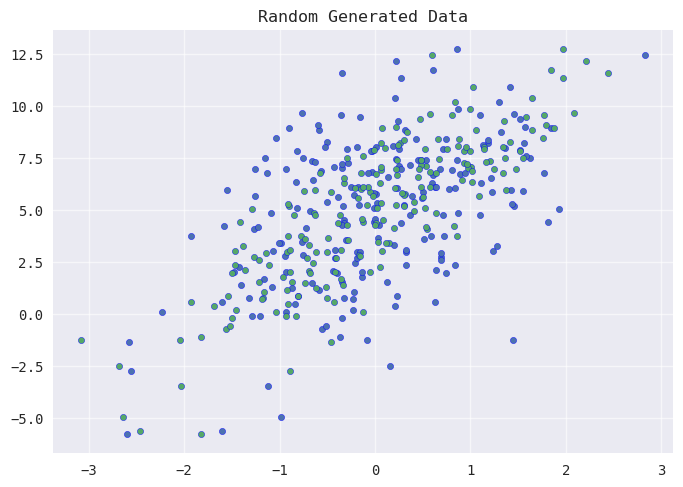

In [4]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.show()

In [5]:
X, X.shape

(tensor([[-4.1755e-01, -4.1392e-01],
         [ 2.2295e-01,  2.2102e+00],
         [ 1.5745e+00,  2.1879e-01],
         [ 1.3025e+00,  8.4132e-01],
         [ 1.1129e+00, -3.2970e-01],
         [-1.6085e+00, -2.4638e+00],
         [ 3.1083e-01,  1.0550e+00],
         [ 2.4129e-01,  1.3487e+00],
         [ 2.0820e-01,  1.6484e+00],
         [-1.0683e+00,  6.9976e-02],
         [ 4.9237e-01, -1.7683e-01],
         [ 1.5902e-01, -2.6792e+00],
         [-7.6543e-01,  3.1069e-02],
         [-1.5477e-01,  1.5775e+00],
         [-4.3261e-01,  1.0066e+00],
         [ 7.7618e-01, -1.4721e-01],
         [ 1.3429e-01,  4.4847e-01],
         [ 1.9313e+00, -1.2856e+00],
         [-8.0029e-02, -2.0473e+00],
         [-8.1278e-01, -8.0384e-01],
         [-1.9070e-01,  1.1410e+00],
         [ 8.5826e-01,  2.3021e-01],
         [-2.2339e+00, -1.2669e-01],
         [ 2.3275e-01, -1.5363e+00],
         [ 1.5165e+00,  4.7077e-01],
         [ 1.3971e-02,  3.0945e-01],
         [-2.0929e-01, -6.5051e-01],
 

In [6]:
y, y.shape

(tensor([ 2.7099, 12.1902,  8.9743, 10.1802,  6.2775, -5.6250,  8.8230,  9.2958,
         10.3668,  3.0258,  5.5523, -2.4959,  3.4338,  9.4626,  7.0443,  5.9834,
          6.5990,  5.0664, -1.2573,  0.8618,  8.0173,  7.3993,  0.0758,  0.8669,
          9.4002,  5.7624,  2.4460,  7.0221,  6.0556,  8.2453,  3.7312,  7.9222,
          4.4194,  5.3602, 12.7439,  7.1168,  6.0853,  3.0892,  7.5103,  3.7652,
          6.3162,  4.5833,  3.0136,  3.5590,  5.8838,  2.3291,  8.0412,  2.7245,
          0.5707, -0.0966,  7.8998,  4.0998,  6.0899,  6.8151,  6.7953,  1.7760,
          5.6530,  6.8982,  0.7420,  3.3950,  7.6049,  6.7849,  0.0965,  5.0835,
          5.9819,  6.3336,  0.7400,  6.0727,  4.8644,  7.5082,  9.8586,  7.2437,
          5.3201,  7.4324, -5.7854,  5.6517, -4.9487, -1.1326, -3.4939,  2.6676,
          9.6822,  7.4165,  6.9733,  2.2772,  0.7030,  9.6090,  4.2682,  2.5828,
         12.4435,  7.2158, -2.7380,  7.9446,  4.2438,  1.9500, -0.2143,  5.7266,
          6.1117,  2.3550,  

In [7]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[-4.1755e-01, -4.1392e-01],
         [ 2.2295e-01,  2.2102e+00],
         [ 1.5745e+00,  2.1879e-01],
         [ 1.3025e+00,  8.4132e-01],
         [ 1.1129e+00, -3.2970e-01],
         [-1.6085e+00, -2.4638e+00],
         [ 3.1083e-01,  1.0550e+00],
         [ 2.4129e-01,  1.3487e+00],
         [ 2.0820e-01,  1.6484e+00],
         [-1.0683e+00,  6.9976e-02],
         [ 4.9237e-01, -1.7683e-01],
         [ 1.5902e-01, -2.6792e+00],
         [-7.6543e-01,  3.1069e-02],
         [-1.5477e-01,  1.5775e+00],
         [-4.3261e-01,  1.0066e+00],
         [ 7.7618e-01, -1.4721e-01],
         [ 1.3429e-01,  4.4847e-01],
         [ 1.9313e+00, -1.2856e+00],
         [-8.0029e-02, -2.0473e+00],
         [-8.1278e-01, -8.0384e-01],
         [-1.9070e-01,  1.1410e+00],
         [ 8.5826e-01,  2.3021e-01],
         [-2.2339e+00, -1.2669e-01],
         [ 2.3275e-01, -1.5363e+00],
         [ 1.5165e+00,  4.7077e-01],
         [ 1.3971e-02,  3.0945e-01],
         [-2.0929e-01, -6.5051e-01],
 

In [8]:
Model = LinearRegression(in_dims=2).to(DEVICE)

In [9]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [11]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([-0.5498, -0.2950], device='cuda:0')
	Epoch 1 | Bias: tensor([1.0440], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.5060, -0.2415], device='cuda:0')
	Epoch 1 | Bias: tensor([1.0940], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.4887, -0.1942], device='cuda:0')
	Epoch 1 | Bias: tensor([1.1440], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.4386, -0.1433], device='cuda:0')
	Epoch 1 | Bias: tensor([1.2128], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.4117, -0.1153], device='cuda:0')
	Epoch 1 | Bias: tensor([1.2940], device='cuda:0')
Epoch 1/25 | Loss: 4.8458
	| Validation Loss: 3.4937

	Epoch 2 | Weights: tensor([-0.3584, -0.0702], device='cuda:0')
	Epoch 2 | Bias: tensor([1.3503], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.3280, -0.0489], device='cuda:0')
	Epoch 2 | Bias: tensor([1.4378], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.3092, -0.0093], device='cuda:0')
	Epoch 2 | Bias: tensor([1.5003], device='cuda:0')
	Epoch 2 | Weights: tensor

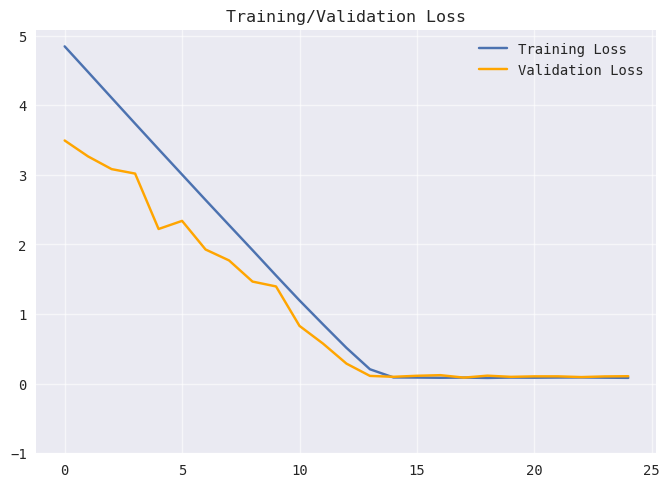

In [12]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-1)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [13]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([1.9906, 2.9773], device='cuda:0')
Trained Bias: tensor([4.9940], device='cuda:0')


In [14]:
# Analytical Solution
# First, bias must be added to the design matrix
X = torch.tensor(np.concatenate([X, np.ones((SIZE, 1))], axis=1), dtype=DTYPE, device='cpu')

w = torch.linalg.inv(X.T @ X) @ X.T @ y
print(f"Analytical Solution for Weights: {w}")

Analytical Solution for Weights: tensor([2.0024, 3.0037, 5.0045])


In [15]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-3.0775, -3.0775],
        [-3.0478, -3.0478],
        [-3.0181, -3.0181],
        [-2.9884, -2.9884],
        [-2.9587, -2.9587],
        [-2.9290, -2.9290],
        [-2.8994, -2.8994],
        [-2.8697, -2.8697],
        [-2.8400, -2.8400],
        [-2.8103, -2.8103],
        [-2.7806, -2.7806],
        [-2.7510, -2.7510],
        [-2.7213, -2.7213],
        [-2.6916, -2.6916],
        [-2.6619, -2.6619],
        [-2.6322, -2.6322],
        [-2.6026, -2.6026],
        [-2.5729, -2.5729],
        [-2.5432, -2.5432],
        [-2.5135, -2.5135],
        [-2.4838, -2.4838],
        [-2.4541, -2.4541],
        [-2.4245, -2.4245],
        [-2.3948, -2.3948],
        [-2.3651, -2.3651],
        [-2.3354, -2.3354],
        [-2.3057, -2.3057],
        [-2.2761, -2.2761],
        [-2.2464, -2.2464],
        [-2.2167, -2.2167],
        [-2.1870, -2.1870],
        [-2.1573, -2.1573],
        [-2.1276, -2.1276],
        [-2.0980, -2.0980],
        [-2.0683, -2.0683],
      

In [16]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

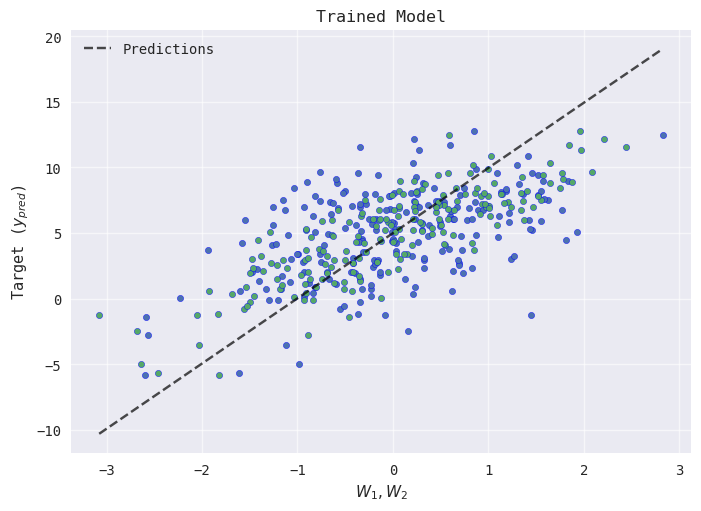

In [17]:
plt.scatter(X[:, 0].numpy(), y.numpy(), s=20, edgecolors="b");
plt.scatter(X[:, 1].numpy(), y.numpy(), s=20, edgecolors="b");
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)");
plt.legend(loc='best');
plt.show()